<a href="https://colab.research.google.com/github/vcepaitis/SSI_EF2_2023/blob/main/jet_normalizing_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/VincentStimper/normalizing-flows/blob/master/examples/real_nvp_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustration of the Usage of the `normflows` Package
## Training a Real NVP model

This notebook illustrates how to use the `normflows` packages by training a simple [Real NVP](https://arxiv.org/abs/1605.08803) model to a 2D distribution consisting on two half moons.

Before we can start, we have to install the package.

In [ ]:
# !pip install normflows

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt

from tqdm import tqdm

In [ ]:
# Helper function for visualization.
import matplotlib.pyplot as plt
%matplotlib inline
# Numpy, h5py, etc
import numpy as np
import h5py

def print_device_usage(device):
  tot_memory = torch.cuda.get_device_properties(device).total_memory/1024.0**3
  reserved_memory = torch.cuda.memory_reserved(device)/1024.0**3
  allocated_memory = torch.cuda.memory_allocated(device)/1024.0**3
  free_memory = reserved_memory-allocated_memory  # free inside reserved
  print('Total memory in Gb: %.2f'%tot_memory)
  print('Reserved memory in Gb: %.2f'%reserved_memory)
  print('Allocated memory in Gb: %.2f'%allocated_memory)
  print('Free memory in Gb: %.2f'%free_memory)


# check if a GPU is available. Otherwise run on CPU
device = 'cpu'
args_cuda = torch.cuda.is_available()
if args_cuda: device = "cuda:0"
print('device : ',device)
if args_cuda: print_device_usage(device)

device :  cpu


In [ ]:
# let's open the file
data_dir = 'Data-MLtutorial/JetDataset/'
fileIN = data_dir+'jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


In [ ]:
target = np.array([])
jetList = np.array([])
jetImages = np.array([])
features_names = dict()
datafiles = ['jetImage_7_100p_0_10000.h5',
            #  'jetImage_7_100p_10000_20000.h5',
            #  'jetImage_7_100p_30000_40000.h5',
            #  'jetImage_7_100p_40000_50000.h5',
            ]
for i_f,fileIN in enumerate(datafiles):
    print("Appending %s" %fileIN)
    f = h5py.File(data_dir + fileIN)
    jetList_file = np.array(f.get("jetConstituentList"))
    target_file = np.array(f.get('jets')[0:,-6:-1])
    jetImages_file = np.array(f.get('jetImage'))
    jetList = np.concatenate([jetList, jetList_file], axis=0) if jetList.size else jetList_file
    target = np.concatenate([target, target_file], axis=0) if target.size else target_file
    jetImages = np.concatenate([jetImages, jetImages_file], axis=0) if jetImages.size else jetImages_file
    del jetList_file, target_file, jetImages_file
    #save particles/nodes features names and their indecies in a dictionary
    if i_f==0:
      for feat_idx,feat_name in enumerate(list(f['particleFeatureNames'])[:-1]):
        features_names[feat_name.decode("utf-8").replace('j1_','')] = feat_idx
    f.close()

target_plot = np.argmax(target, axis=1)
label_names= ["gluon", "quark", "W", "Z", "top"]
# features_to_consider = 'etarel,phirel,pt,e,ptrel,erel,deltaR'.split(',')
features_to_consider = 'pt'.split(',')
features_idx = [features_names[name] for name in features_to_consider]
print(features_names)
print(features_to_consider)
max_pt = np.max(jetList[:,:,5])
jetList[:,:,5] = jetList[:,:,5]/max_pt*4
jetList = jetList[:,:2,features_idx]
jetList = jetList[target_plot==3].squeeze()
# jetList = jetList.reshape(-1, 4)
print(jetList.shape)

Appending jetImage_7_100p_0_10000.h5
{'px': 0, 'py': 1, 'pz': 2, 'e': 3, 'erel': 4, 'pt': 5, 'ptrel': 6, 'eta': 7, 'etarel': 8, 'etarot': 9, 'phi': 10, 'phirel': 11, 'phirot': 12, 'deltaR': 13, 'costheta': 14, 'costhetarel': 15}
['pt']
(1961, 2)


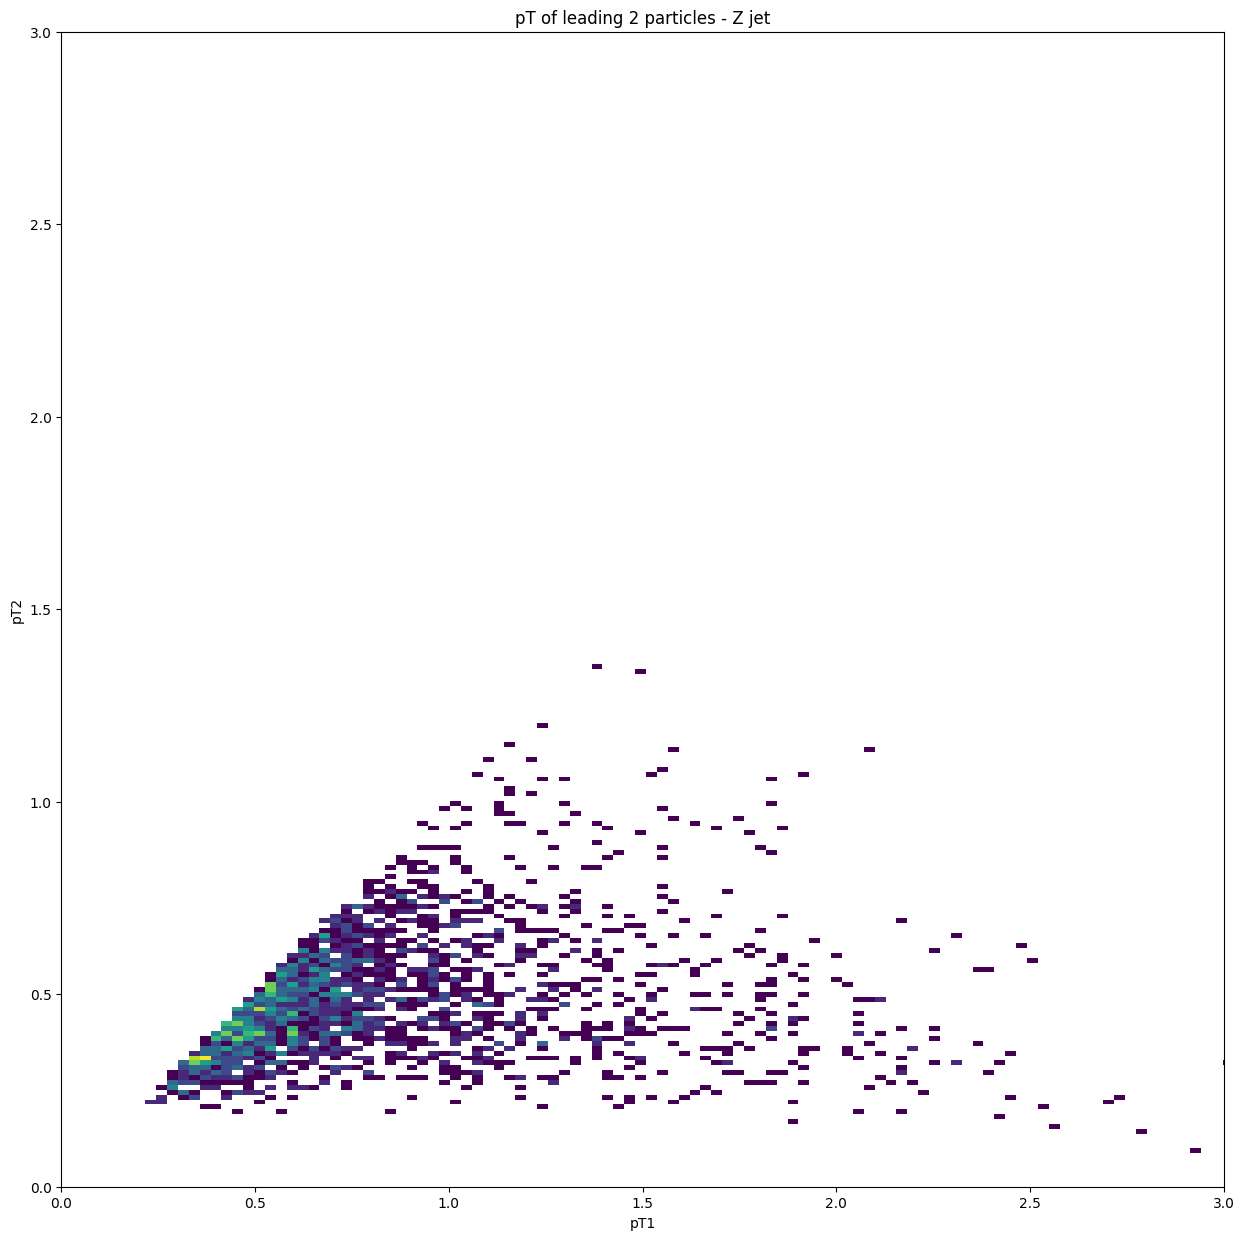

In [ ]:
plt.figure(figsize=(15, 15))
plt.hist2d(jetList[:,0],jetList[:,1], bins=100, cmin = 1)
plt.xlabel("pT1")
plt.ylabel("pT2")
plt.title("pT of leading 2 particles - Z jet")
plt.xlim(0,3)
plt.ylim(0,3)
plt.show()

After importing the required packages, we want to create a `nf.NormalizingFlow` model. Therefore, we need a base distribution, which we set to be a Gaussian, and a list of flow layers. The flow layers are simply affine coupling layers, whereby `nf.AffineCouplingBlock` already includes the splitting and merging of the features as it is done in coupling. We also swap the features after each layer to ensure that they are all modified.

In [ ]:
# Set up model

# Define 2D Gaussian base distribution
n_feat = 2
if n_feat%2!=0:
    raise Exception("Even number of features is required!")
base = nf.distributions.base.DiagGaussian(n_feat)
print(base)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([int(n_feat/2), 64, 64, n_feat], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))

# Construct flow model
model = nf.NormalizingFlow(base, flows)

DiagGaussian()


In [ ]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

This is our target distribution.

In [ ]:
# Define target distribution
target = nf.distributions.TwoMoons()
print(torch.exp(target.log_prob(target.sample(10))))

tensor([0.9786, 0.2015, 0.8645, 0.7341, 0.1829, 0.7842, 0.8959, 0.8574, 0.7563,
        0.7812])


In [ ]:
# Plot target distribution
grid_size = 100
xx, yy = torch.meshgrid(torch.linspace(0, 3, grid_size), torch.linspace(0, 3, grid_size))
zz = torch.cat([xx.unsqueeze(-1), yy.unsqueeze(-1)], -1).view(-1, 2)
print(zz.shape)

# xx, yy, ww, kk = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(0, 3, grid_size), torch.linspace(-3, 3, grid_size), torch.linspace(0, 3, grid_size))
# zz = torch.cat([xx.unsqueeze(-1), yy.unsqueeze(-1), ww.unsqueeze(-1), kk.unsqueeze(-1)], -1).view(-1, 4)
# zz = zz.to(device)


log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

torch.Size([10000, 2])


AttributeError: 'numpy.ndarray' object has no attribute 'log_prob'

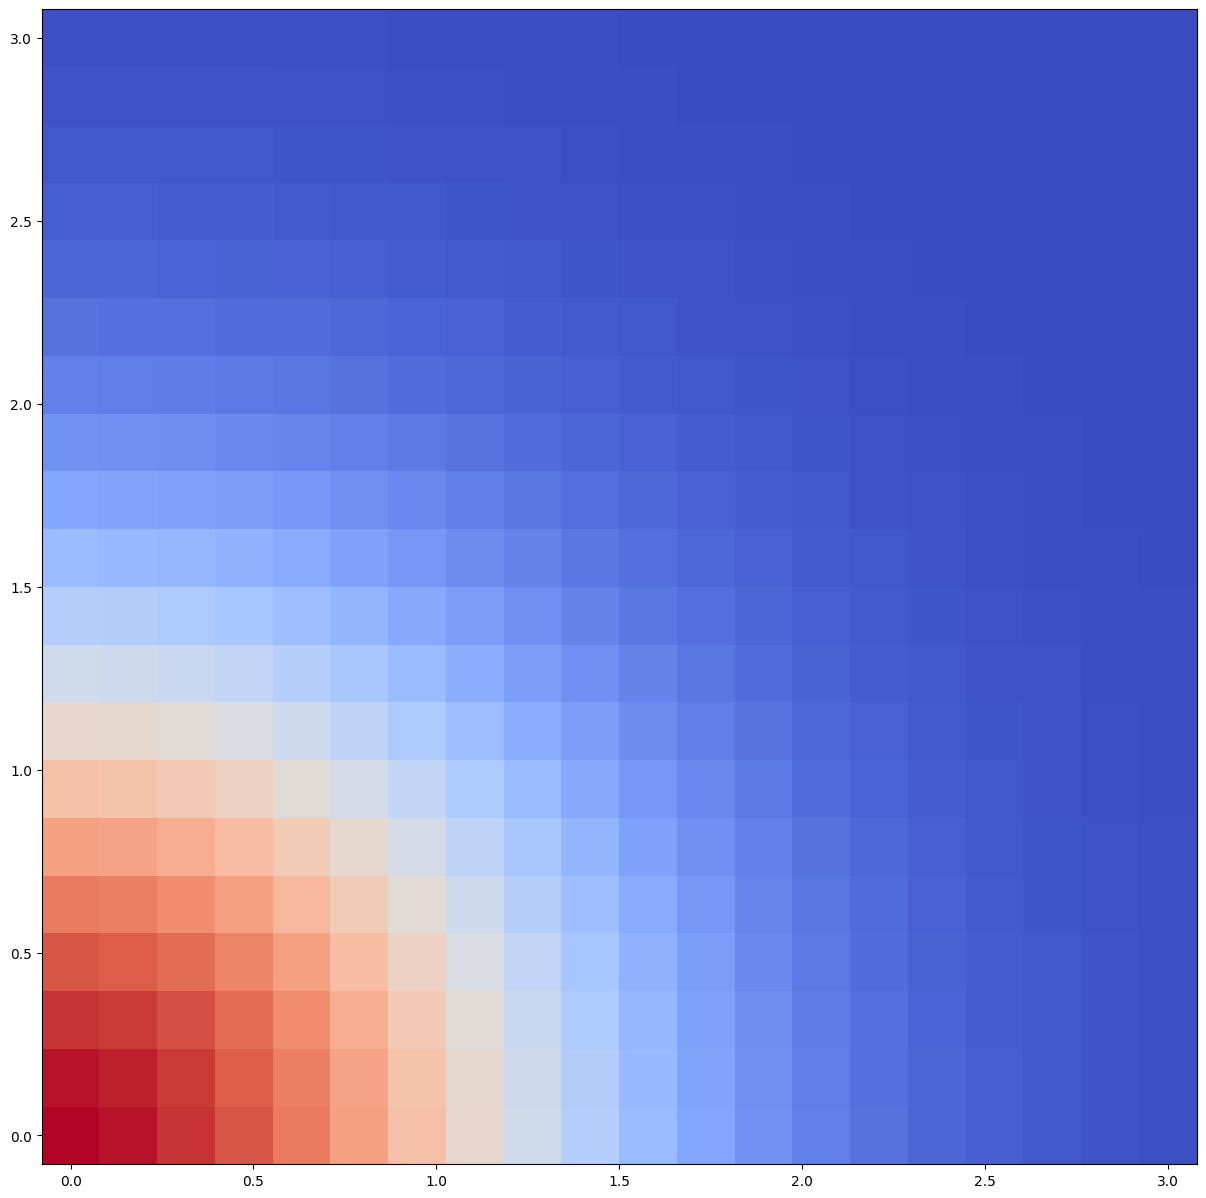

In [ ]:
# Plot initial flow distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
plt.gca().set_aspect('equal', 'box')
plt.show()

Now, we are ready to train the flow model. This can be done in a similar fashion as standard neural networks. Since we use samples from the target for training, we use the forward KL divergence as objective, which is equivalent to maximum likelihood.

This is our trained flow model!

Note that there might be a density filament connecting the two modes, which is due to an architectural limitation of normalizing flows, especially prominent in Real NVP. You can find out more about it in [this paper](https://proceedings.mlr.press/v151/stimper22a).

  7%|▋         | 4/60 [00:07<01:34,  1.69s/it]

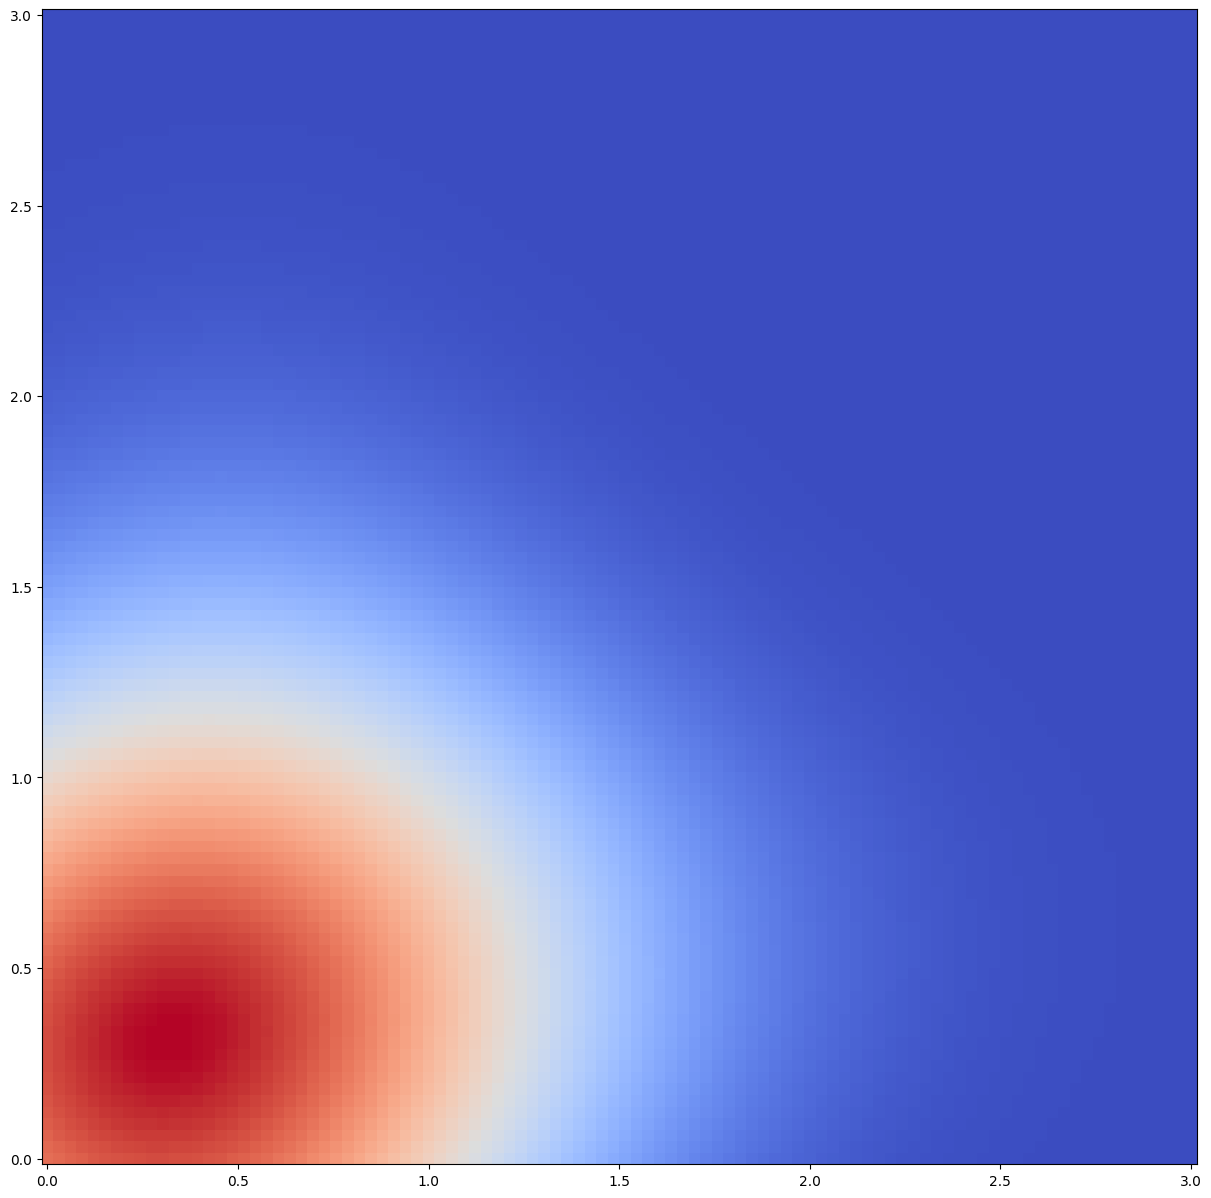

 15%|█▌        | 9/60 [00:19<01:43,  2.03s/it]

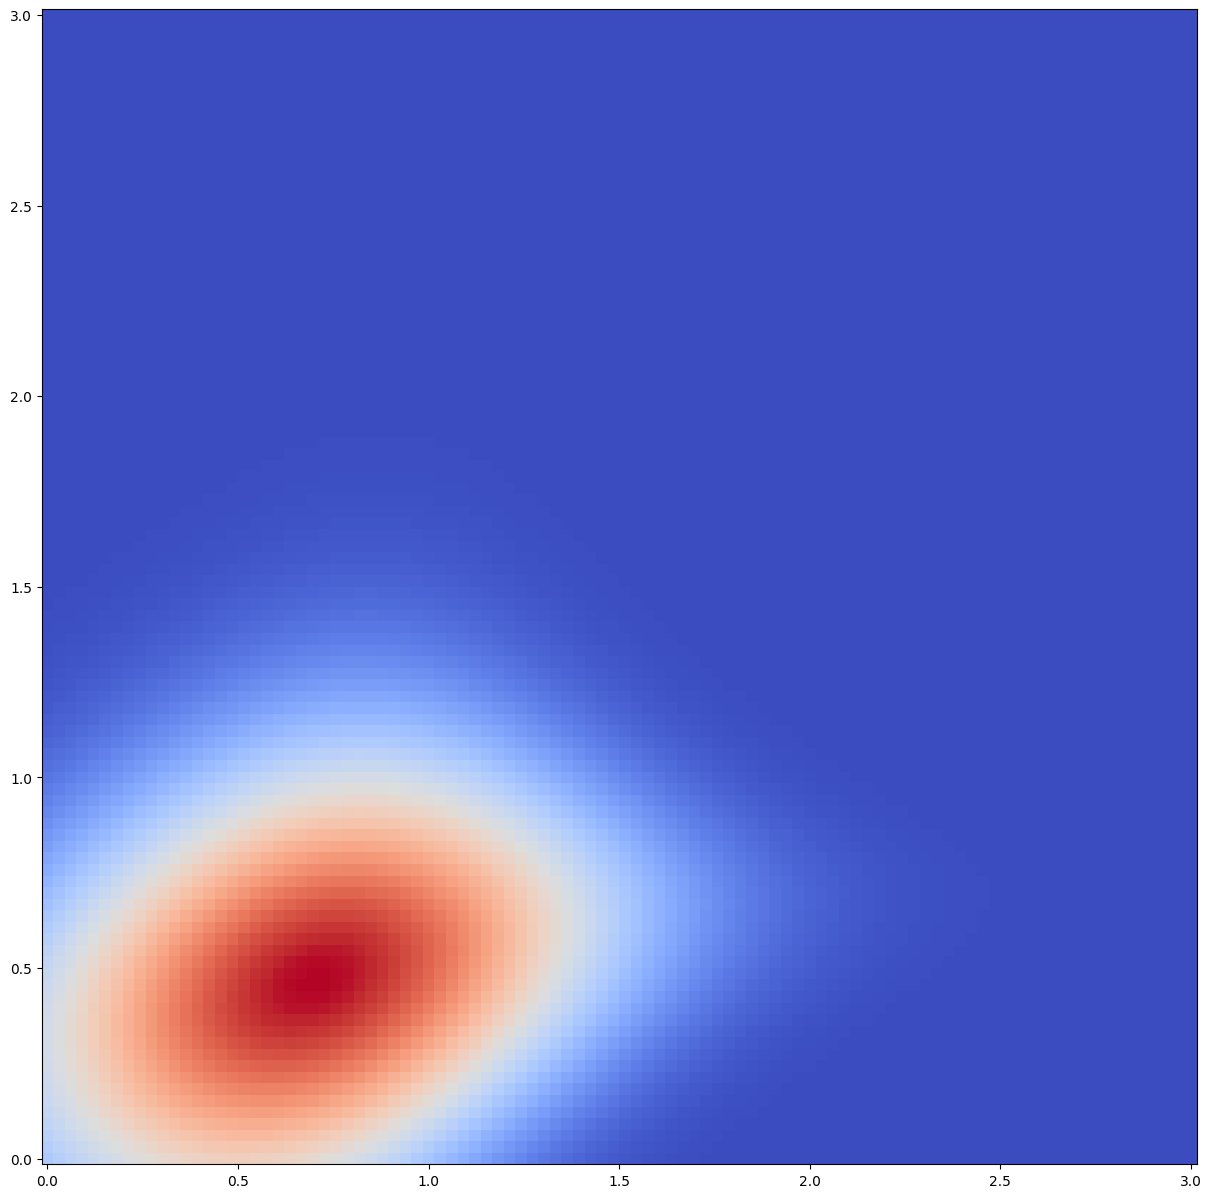

 23%|██▎       | 14/60 [00:33<01:44,  2.28s/it]

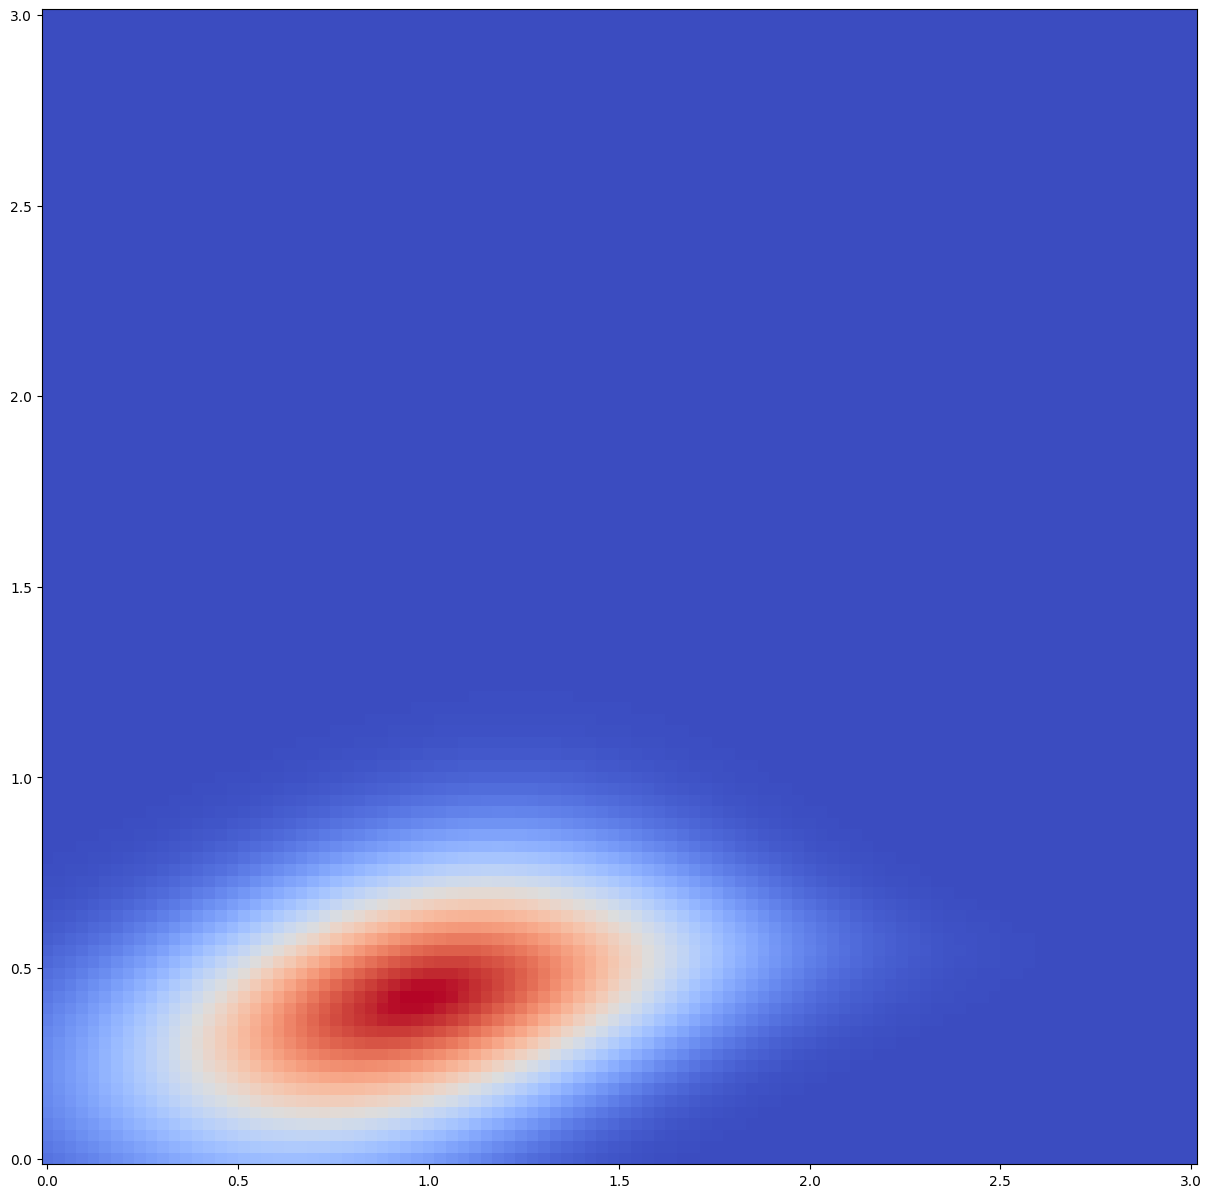

 32%|███▏      | 19/60 [00:44<01:11,  1.74s/it]

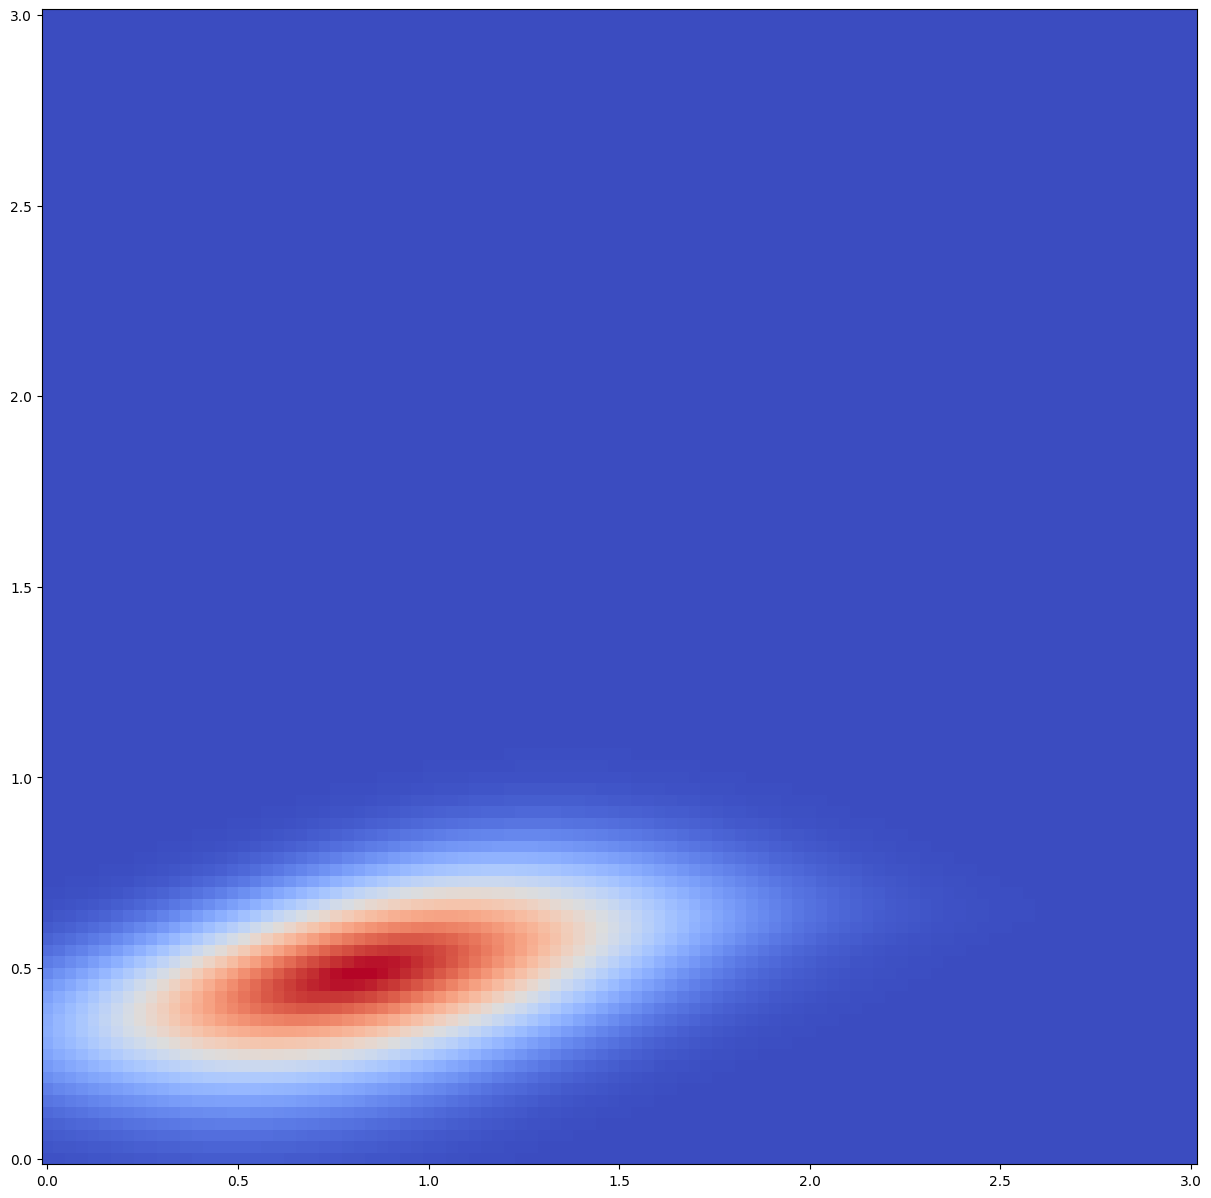

 40%|████      | 24/60 [00:58<01:16,  2.13s/it]

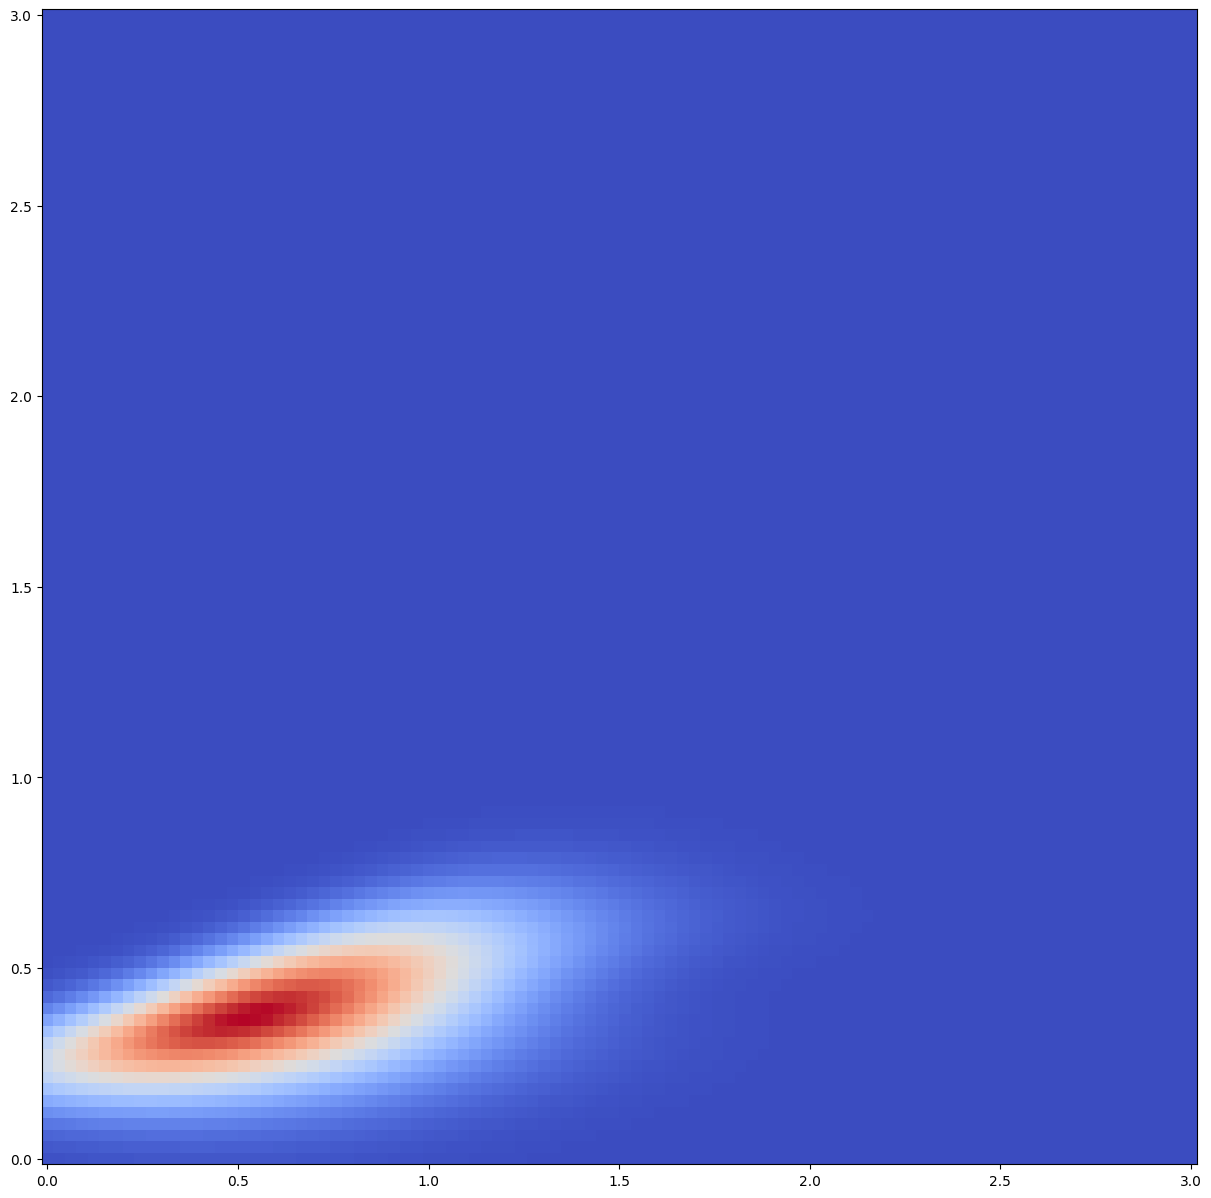

 48%|████▊     | 29/60 [01:10<01:00,  1.94s/it]

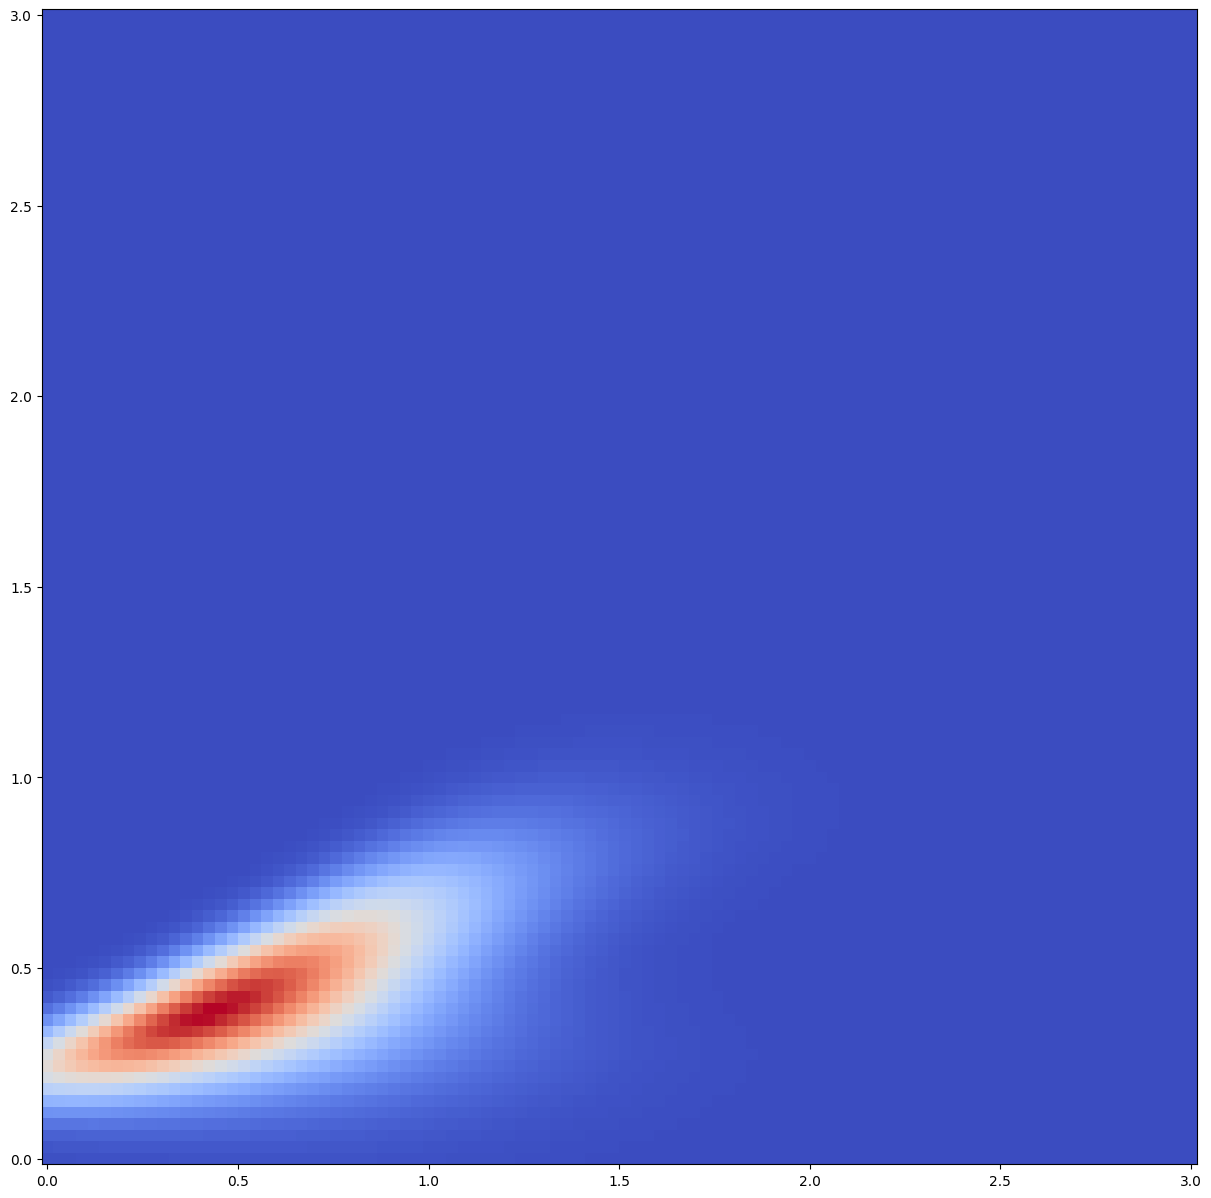

 57%|█████▋    | 34/60 [01:25<01:03,  2.43s/it]

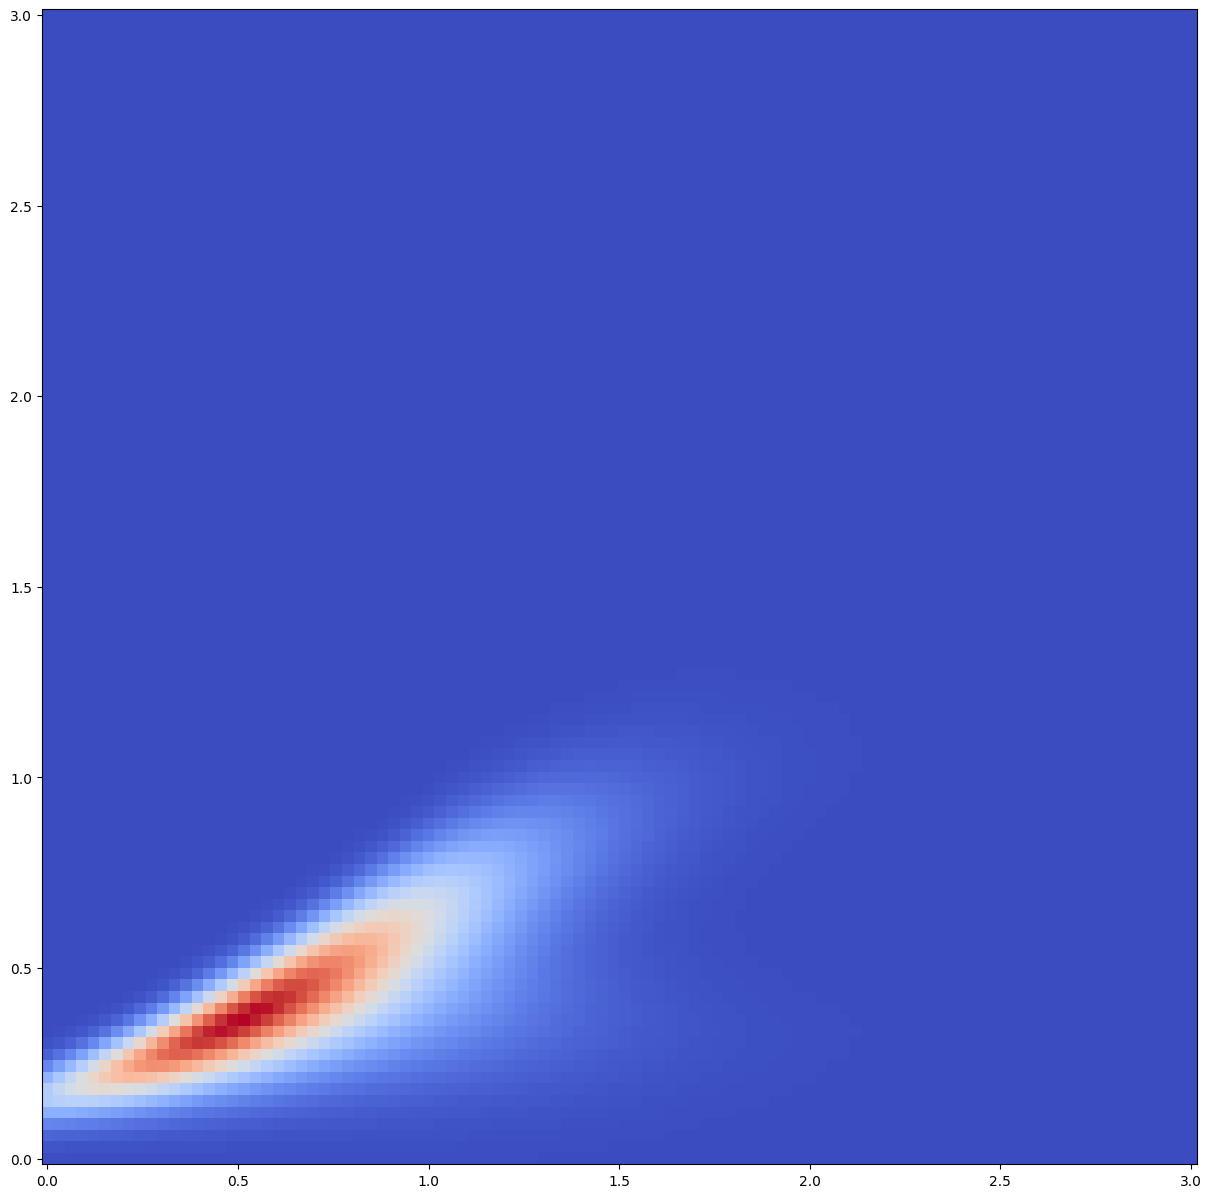

 65%|██████▌   | 39/60 [01:39<00:49,  2.36s/it]

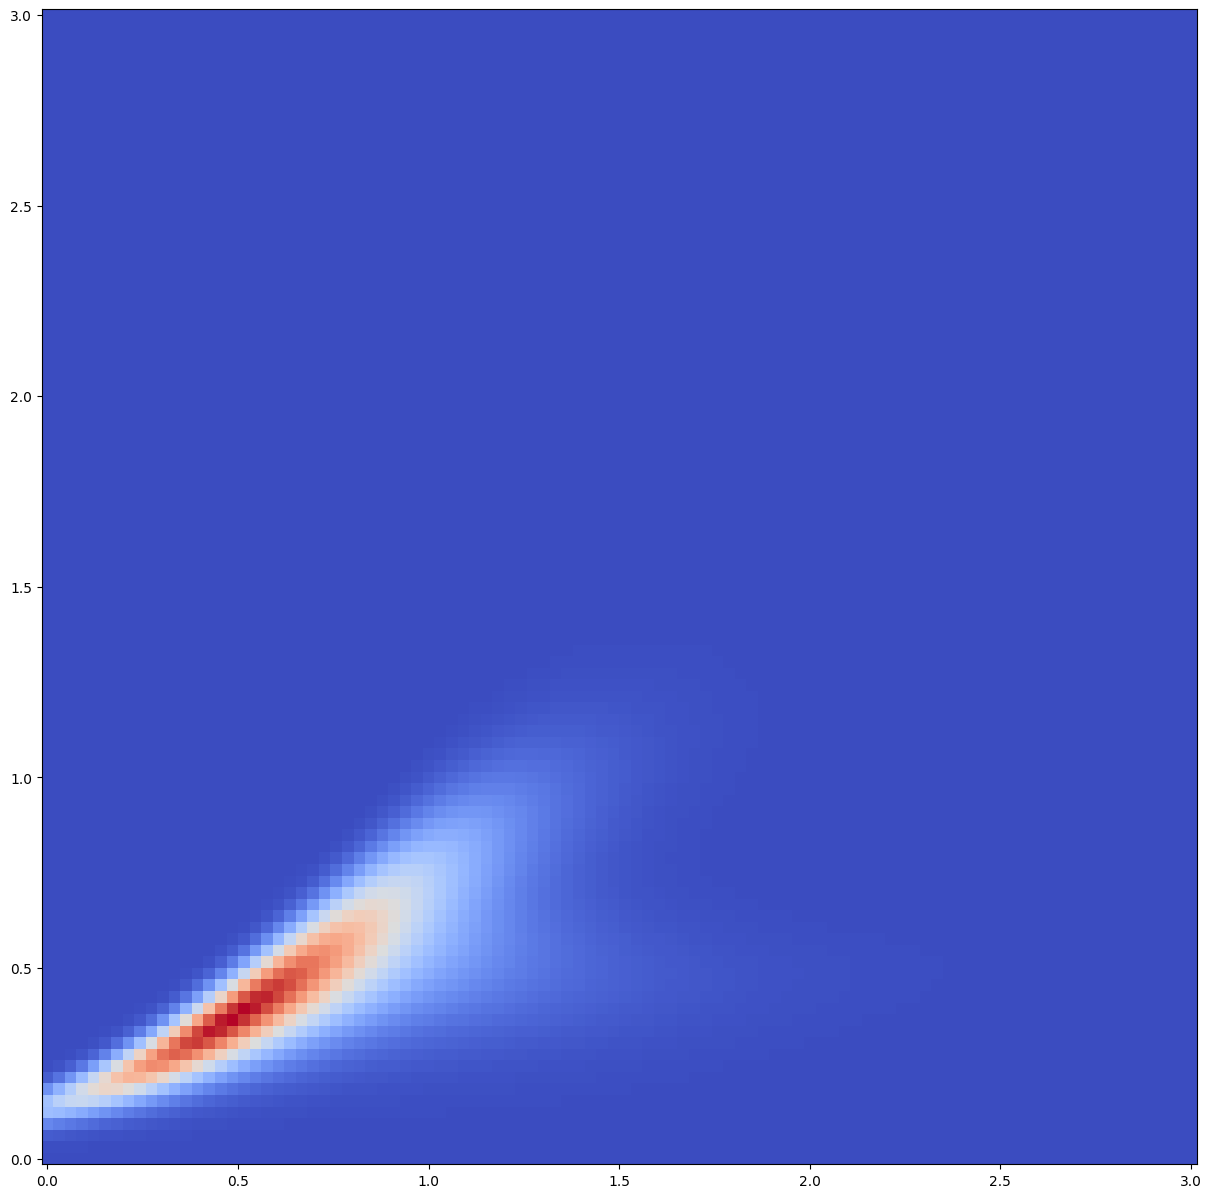

 73%|███████▎  | 44/60 [01:52<00:34,  2.18s/it]

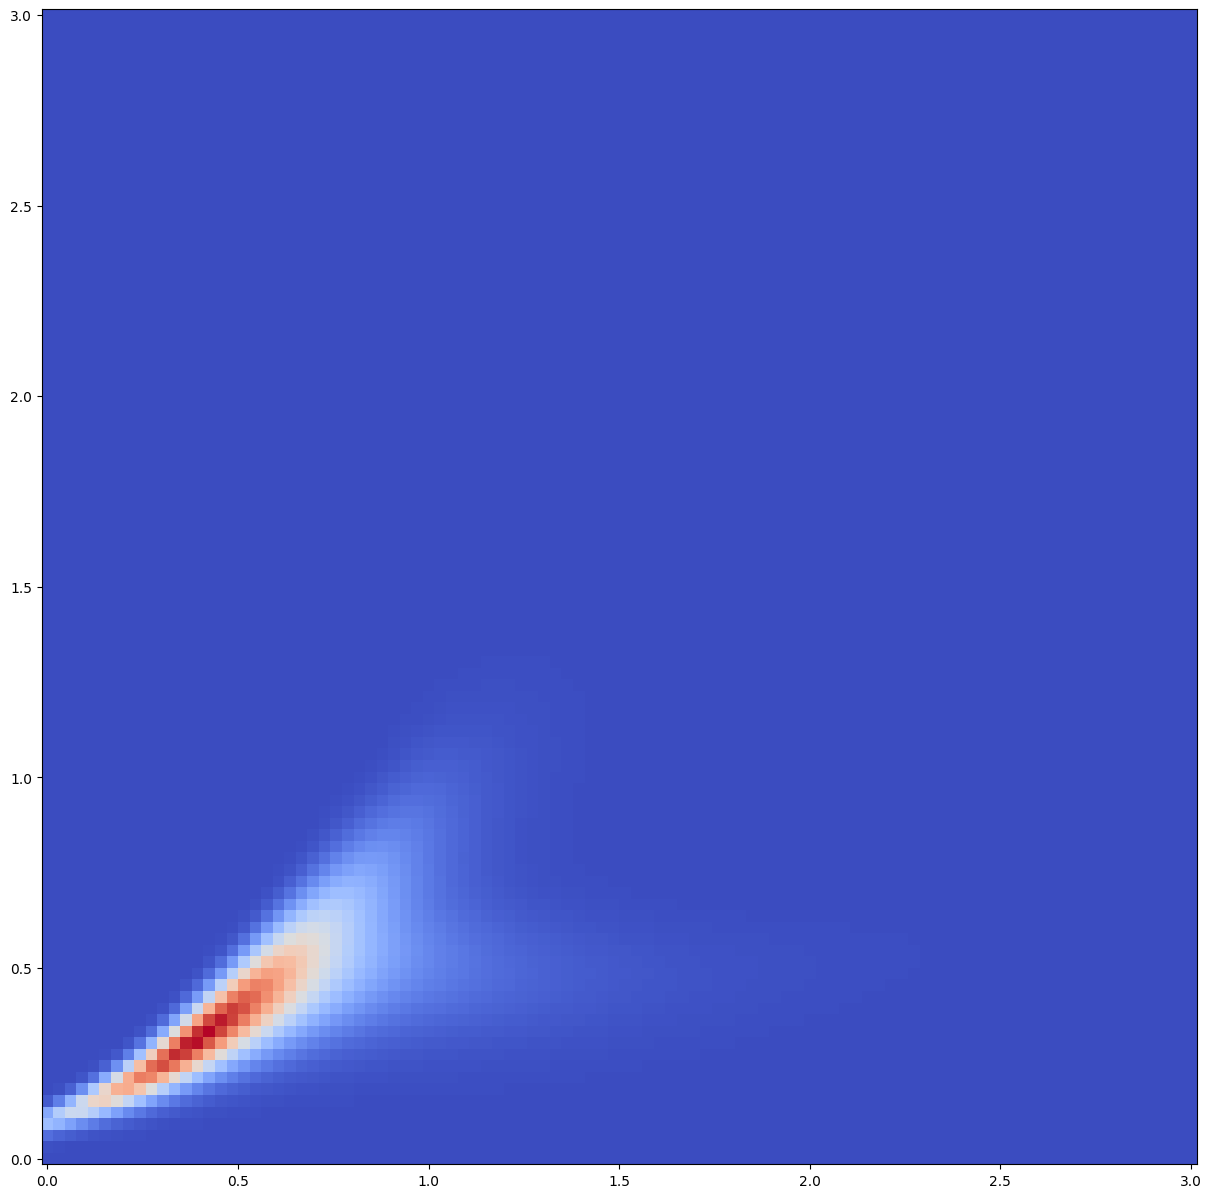

 82%|████████▏ | 49/60 [02:06<00:27,  2.48s/it]

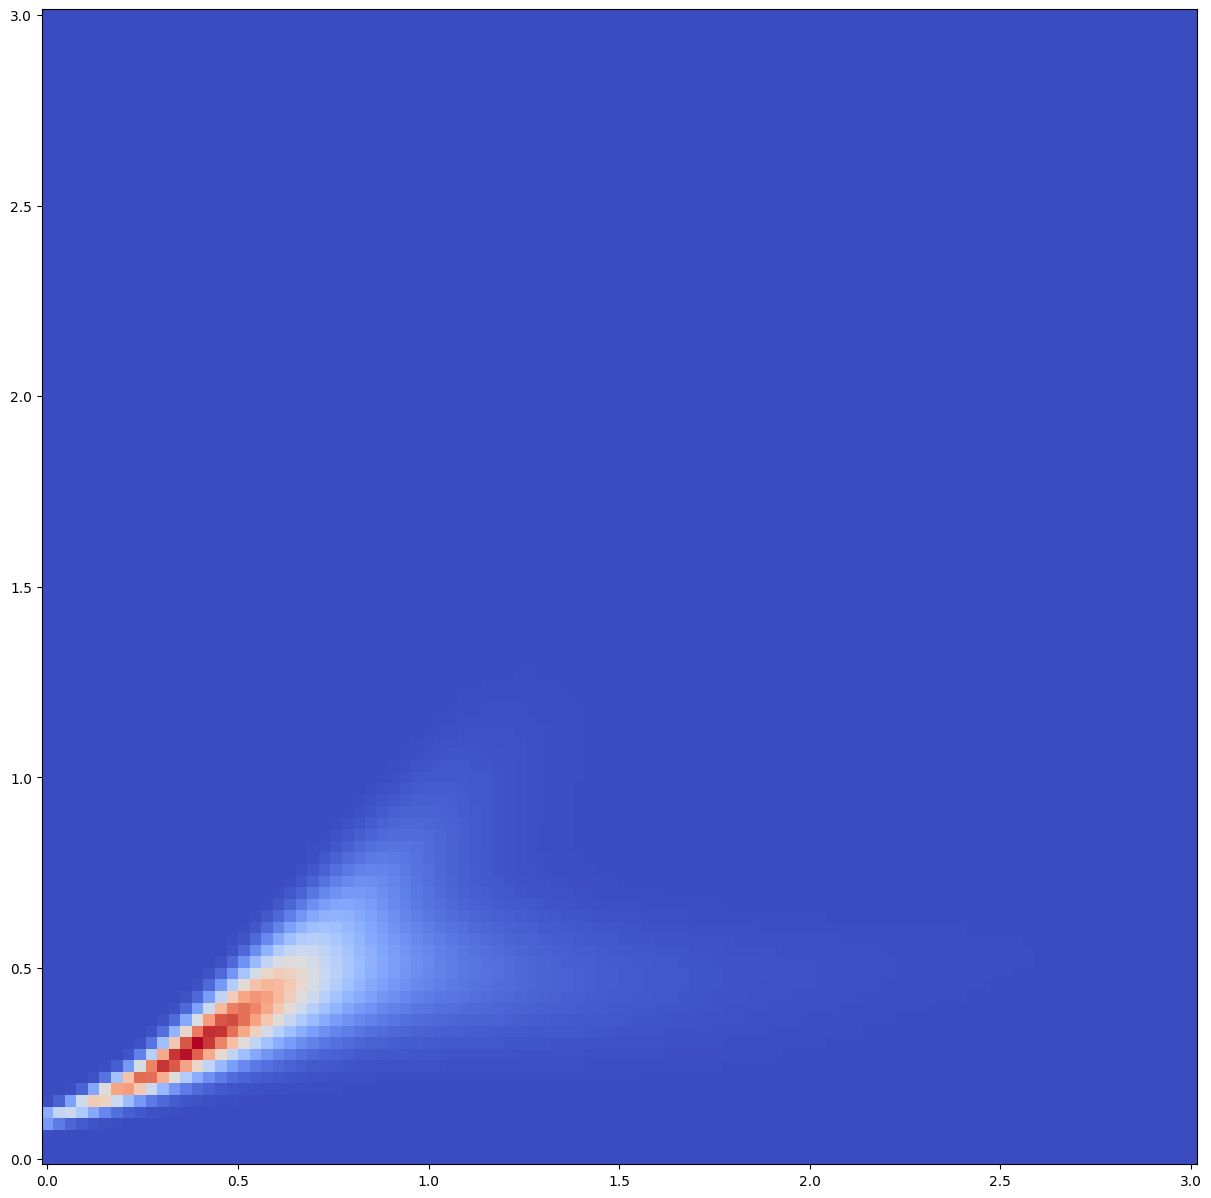

 90%|█████████ | 54/60 [02:19<00:14,  2.38s/it]

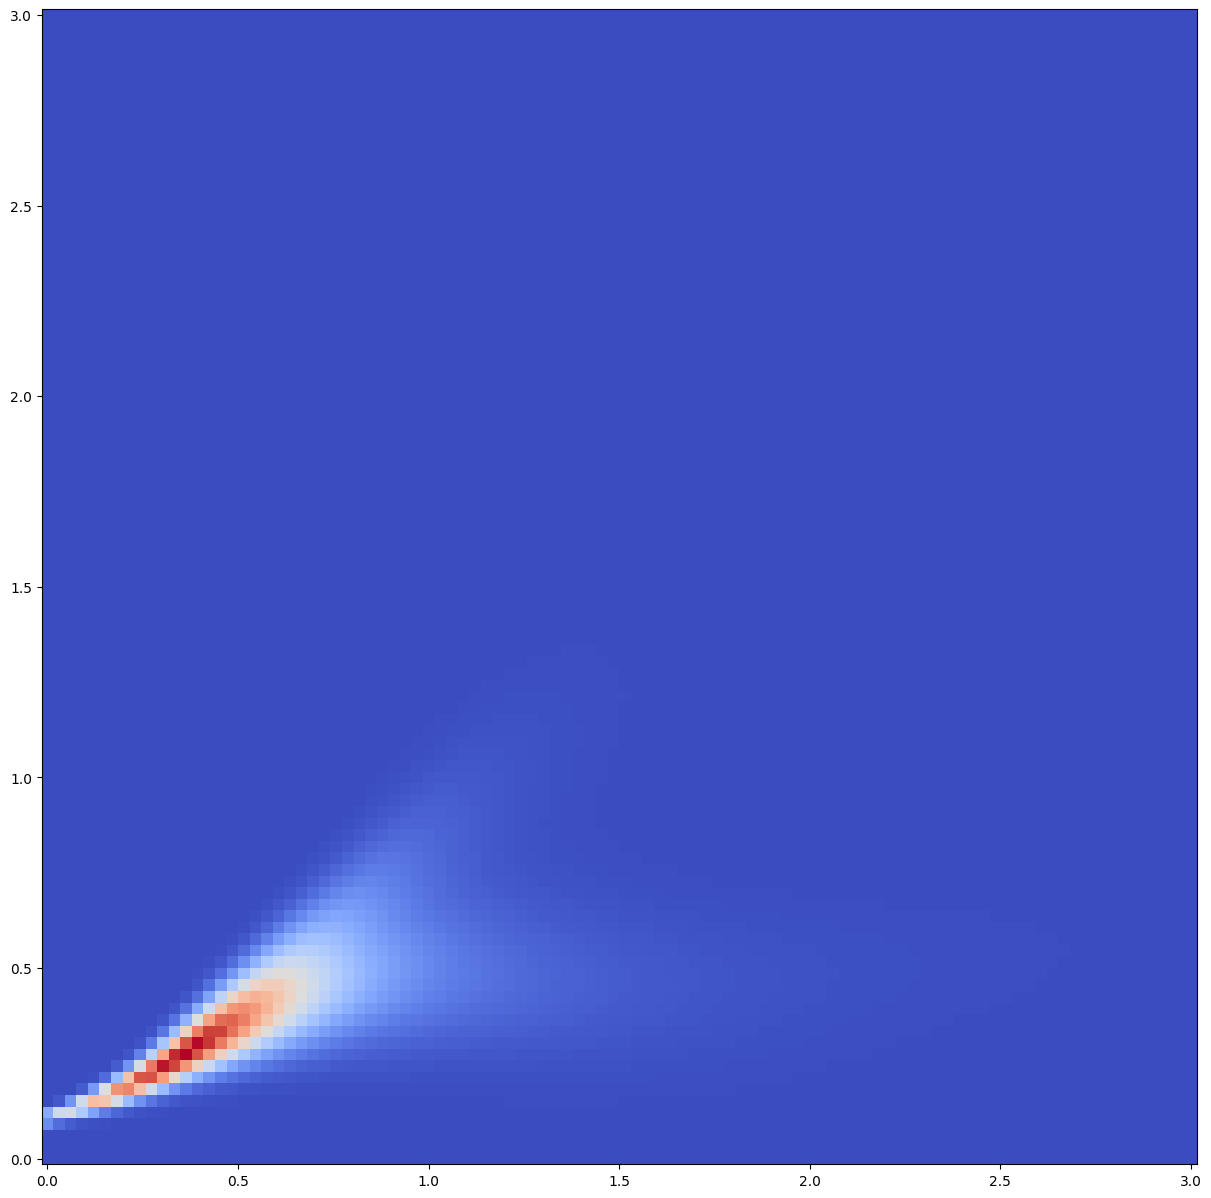

 98%|█████████▊| 59/60 [02:32<00:02,  2.23s/it]

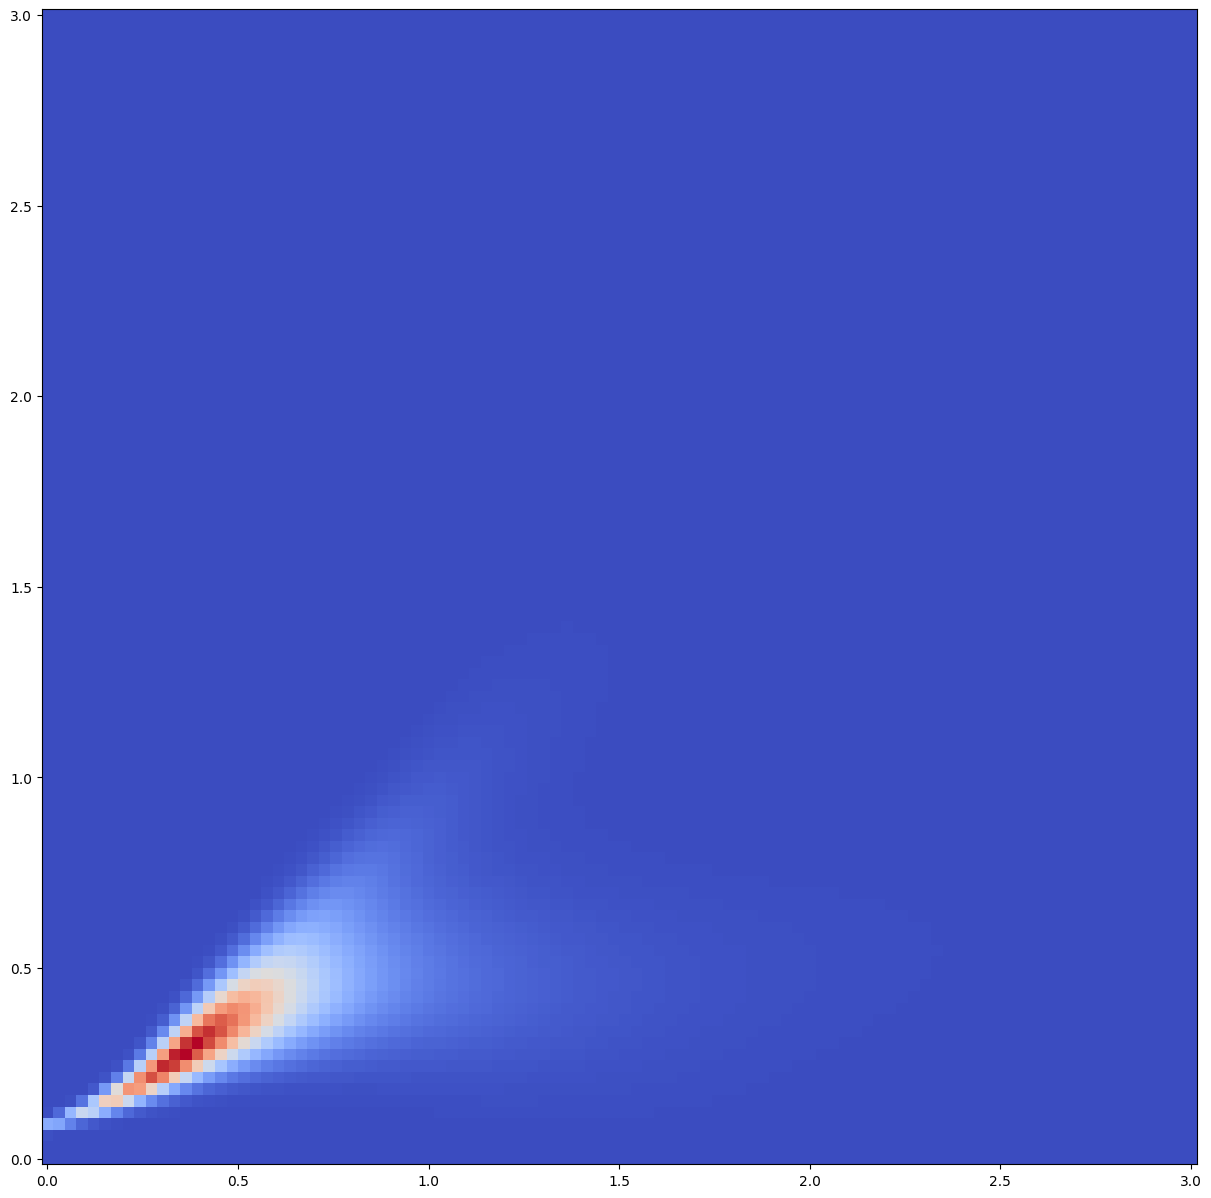

100%|██████████| 60/60 [02:38<00:00,  2.64s/it]


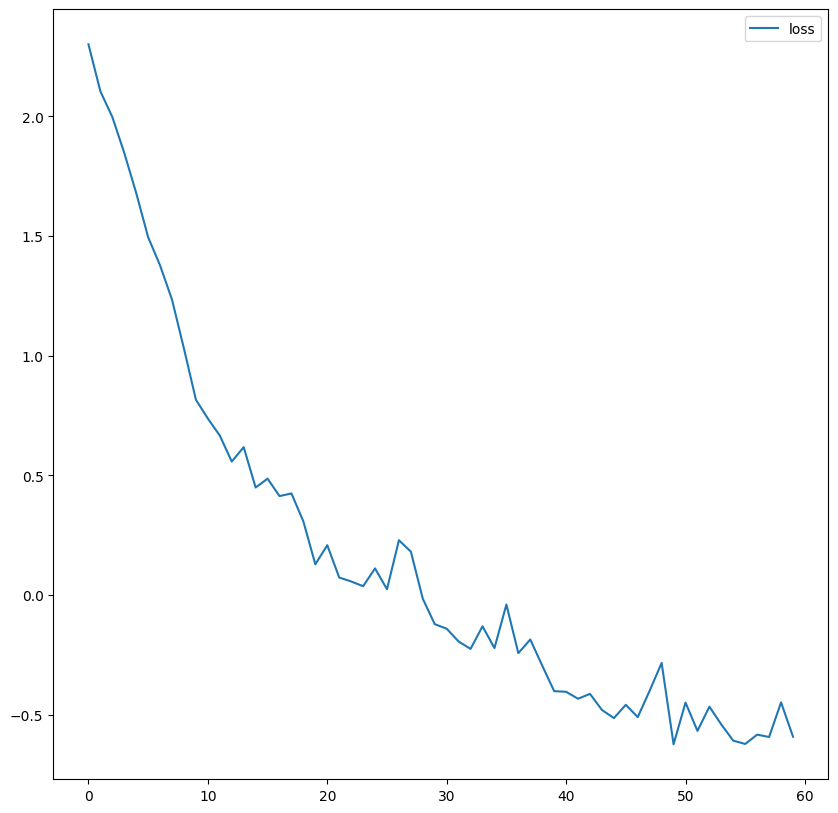

In [ ]:
import random
# Train model
max_iter = 60
num_samples = 2 ** 9
show_iter = 5

# print(prob.data.numpy().reshape(20,20,20,20)[10,:,10,:].shape)
# plt.pcolormesh(xx[10,:,10,:], yy[10,:,10,:], prob.data.numpy().reshape(20,20,20,20)[10,:,10,:], cmap='coolwarm')
# plt.gca().set_aspect('equal', 'box')
# plt.show()
# raise Exception()
loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()

    # Get training samples
    # x = target.sample(num_samples).to(device)
    x = torch.Tensor(jetList[random.sample(range(jetList.shape[0]), num_samples)]).squeeze()
    # Compute loss
    loss = model.forward_kld(x)

    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()

    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

    # Plot learned distribution
    if (it + 1) % show_iter == 0:
        model.eval()
        log_prob = model.log_prob(zz)
        model.train()
        prob = torch.exp(log_prob.to('cpu').view(*xx.shape))
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        # plt.pcolormesh(xx[10,:,10,:], yy[10,:,10,:], prob.data.numpy().reshape(20,20,20,20)[10,:,10,:], cmap='coolwarm')
        plt.pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')
        plt.gca().set_aspect('equal', 'box')
        plt.show()

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

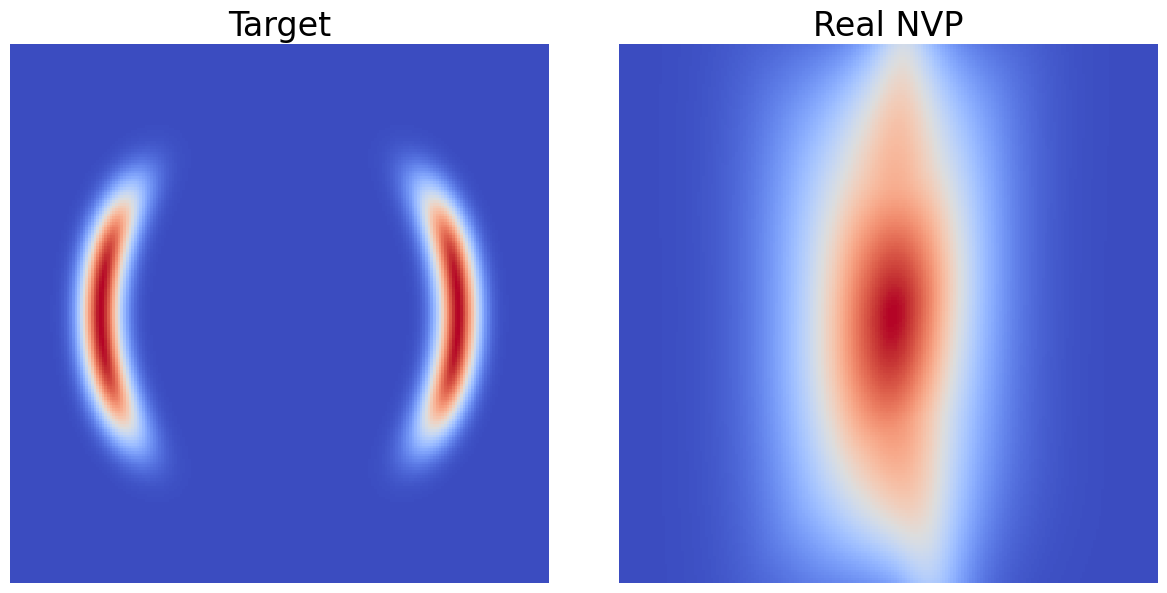

In [ ]:
# Plot target distribution
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))

log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[0].set_aspect('equal', 'box')
ax[0].set_axis_off()
ax[0].set_title('Target', fontsize=24)

# Plot learned distribution
model.eval()
log_prob = model.log_prob(zz).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[1].set_aspect('equal', 'box')
ax[1].set_axis_off()
ax[1].set_title('Real NVP', fontsize=24)

plt.subplots_adjust(wspace=0.1)

plt.show()